In [1]:
import warnings, pickle, os, itertools
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc('figure', titlesize=16)

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1
%aimport utils.revision, models, systematic_comparison

In [2]:
class Notebook:
    RE_DERIVE = False
    SYS_RESULTS_DIR = Path('models/systematic_comparison/')
    TIME_RESULTS_DIR = Path('models/time_tough_with_h1_filtered/')
    TIME_PERSISTED_RESULTS_DIR = Path('models/time_far_short')
    IMAGE_DIR = Path('images/revision/')


## Data Loading

In [3]:
from dataset import SCIData, SCICols
sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(within=1, return_subcols=True)
    .derive_critical_care(within=9999)
)
scii = SCIData(scii[
    (~((scii.BreathingDevice=='NIV - NIV')&(scii.AdmitWard=='HH1M'))) &
    (~scii.AdmissionMethodDescription.isin(['BOOKED ADMISSION ', 'ELECTIVE PLANNED']))
].copy())

In [4]:
from utils.revision import get_train_test_indexes
SCI_TRAIN_IDX, SCI_TEST_IDX, UNSEEN_IDX, UNSEEN_MASK, PRECOVID_IDX, PRECOVID_MASK = get_train_test_indexes(scii)

In [5]:
PRETTY_PRINT_NUM_COLUMNS = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
PRETTY_PRINT_BINARY_COLUMNS = dict(
    DiedWithin30Days = '30-day Mortality',
    DiedDuringStay = 'In-hospital Mortality',
    AVCPU_Alert = 'AVCPU-A',
    AssistedBreathing = 'Assisted Breathing',
    Female='Female',
    LyingDown='Lying Down',
    Nausea='Nausea',
    Pain='Pain',
    VomitingSinceLastRound='Vomiting',
    Readmission='Readmission',
    SentToSDEC='SDEC',
    CriticalCare='Critical Care',
    CriticalEvent='Critical Event'
)

PRETTY_PRINT_CATEGORICAL_COLUMNS = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='ED Diagnosis'
)

PRETTY_PRINT_FEATURE_NAMES = PRETTY_PRINT_BINARY_COLUMNS | PRETTY_PRINT_NUM_COLUMNS | PRETTY_PRINT_CATEGORICAL_COLUMNS

## Model Re-Training

In [6]:
from models import Estimator_L1Regression, Estimator_LinearSVM, Estimator_LightGBM, Estimator_L2Regression, Estimator_ElasticNetRegression, Estimator_XGBoost, Estimator_LogisticRegression

PRETTY_PRINT_FEATURE_GROUPS = {
    'Reference': 'Reference',
    'news': 'Vitals',
    'news_with_phenotype': '& Obs',
    'with_labs': '& Labs',
    'with_notes_and_labs': '& Notes',
    'with_notes_labs_and_hospital': '& Services',
}

SCORED_FEATURE_GROUPS = {
    'Reference': 'Reference',
    'news_scores': 'news',
    'news_scores_with_phenotype': 'news_with_phenotype',
    'scores_with_labs': 'with_labs',
    'scores_with_notes_and_labs': 'with_notes_and_labs',
    'scores_with_notes_labs_and_hospital': 'with_notes_labs_and_hospital',
}

FEATURE_GROUPS = scii.feature_group_combinations
FEATURE_GROUPS = {k:v for k,v in FEATURE_GROUPS.items() if k in list(PRETTY_PRINT_FEATURE_GROUPS.keys())+list(SCORED_FEATURE_GROUPS.keys())}

PRETTY_PRINT_ESTIMATORS = dict(
    NEWS2='NEWS2',
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)

ESTIMATORS = {_._name: _ for _ in [
    Estimator_LightGBM,
    Estimator_L2Regression,
    Estimator_XGBoost,
    Estimator_LinearSVM,
    Estimator_L1Regression,
    Estimator_ElasticNetRegression,
    Estimator_LogisticRegression,
]}

STUDY_GRID = list(itertools.product(ESTIMATORS.keys(), FEATURE_GROUPS.keys()))

In [7]:
import optuna
from sklearn.calibration import CalibratedClassifierCV
from systematic_comparison import get_xy, PipelineFactory

def run_pretuned(scii, estimator_name, feature_group_name, cv_jobs=4, explain_models=['LightGBM', 'L2Regression'], outcome_within=1):
    params = optuna.load_study(
        study_name = f'{estimator_name}_None_Within-1_{feature_group_name}', 
        storage=f'sqlite:///{Notebook.SYS_RESULTS_DIR}/{estimator_name}.db'
    ).best_params
    
    estimator = ESTIMATORS[estimator_name]
    if estimator._name == 'LinearSVM':
        params = estimator.compile_parameters(estimator._tuning_params_default)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X, y = scii.xy(
            x=FEATURE_GROUPS[feature_group_name],
            imputation = estimator._requirements['imputation'],
            fillna = estimator._requirements['fillna'],
            ordinal_encoding = estimator._requirements['ordinal'],
            onehot_encoding = estimator._requirements['onehot'],
            outcome_within=outcome_within
        )
    X_train, y_train = SCIData(X.loc[SCI_TRAIN_IDX]), y.loc[SCI_TRAIN_IDX].values

    pipeline_factory = PipelineFactory(
        estimator=estimator, resampler=None, X_train=X_train, y_train=y_train,
    )

    model = CalibratedClassifierCV(
        pipeline_factory(**params), cv=cv_jobs, method="isotonic", n_jobs=cv_jobs,
    ).fit(X_train, y_train)


    y_pred_proba = model.predict_proba(X.loc[SCI_TEST_IDX])[:,1]
    y_pred_proba_unseen = y_pred_proba[UNSEEN_MASK]
    y_pred_proba_precovid = y_pred_proba[PRECOVID_MASK]

    explanations = None
    if estimator_name in explain_models:
        explanations = estimator.explain_calibrated(
            model, X_train, SCIData(X.loc[SCI_TEST_IDX]), cv_jobs=cv_jobs
        )

    return y_pred_proba, y_pred_proba_unseen, y_pred_proba_precovid, explanations, model

if Notebook.RE_DERIVE:
    RESULTS = {}
    for estimator_name, feature_group_name in (pbar := tqdm(STUDY_GRID)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        RESULTS[(estimator_name, feature_group_name)] = run_pretuned(scii, estimator_name, feature_group_name)

        with open(Notebook.SYS_RESULTS_DIR/'results_revision_2.bin', 'wb') as file:
            pickle.dump(RESULTS, file)
else:
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2.bin', 'rb') as file:
            RESULTS = pickle.load(file)

In [9]:
from utils.revision import get_discriminative_metrics
Y_TRUES = {
    'Complete': scii.CriticalEvent.loc[SCI_TEST_IDX],
    'Unseen': scii.CriticalEvent.loc[UNSEEN_IDX],
    'Pre-Covid': scii.CriticalEvent.loc[PRECOVID_IDX]
}
def get_full_metrics_tables(results):
    metrics = {
        'Complete': [],
        'Unseen': [],
        'Pre-Covid': []
    }
    for (estimator_name, feature_group_name), y_preds in results.items():
        for y_pred_proba, (y_true_name, y_true) in zip(y_preds, Y_TRUES.items()):
            if feature_group_name in SCORED_FEATURE_GROUPS.keys():
                feature_group_name = SCORED_FEATURE_GROUPS[feature_group_name]
                
            metrics[y_true_name].append(dict(
                Estimator = PRETTY_PRINT_ESTIMATORS[estimator_name],
                Features = PRETTY_PRINT_FEATURE_GROUPS[feature_group_name],
            ) | get_discriminative_metrics(
                y_true, y_pred_proba
            ))
    
    for y_true_name, y_true in Y_TRUES.items():
        metrics[y_true_name].append(dict(
            Estimator='NEWS2',
            Features='Reference'
        ) | get_discriminative_metrics(
            y_true, scii.NEWS_score.loc[y_true.index]
        ))

    return {
        y_true_name: pd.DataFrame(metric_list) for y_true_name, metric_list in metrics.items()
    }

if Notebook.RE_DERIVE:
    METRICS = get_full_metrics_tables(RESULTS)
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_metrics.bin', 'wb') as file:
        pickle.dump(METRICS, file)
else:
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_metrics.bin', 'rb') as file:
            METRICS = pickle.load(file)

## Metrics

In [230]:
print(f"Maximum increase in AP: {METRICS['Complete'].AP.max() - METRICS['Complete'].set_index('Estimator').loc['NEWS2', 'AP']:.3f}")

Maximum increase in AP: 0.366


### Summary Table

In [130]:
def summary_metrics_select_estimators(metrics, estimators=['LightGBM', 'LR-L2']):
    df = pd.DataFrame(dict(
            Metric=metric,
            Estimator=_['Estimator'],
            Features=_['Features'],
            Value=f"{_[metric]:.3f}",
            Dataset=dataset
        ) for dataset, df in metrics.items() for _ in df[df.Estimator.isin(estimators)].to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]
    return df

result_metrics_summary = summary_metrics_select_estimators(METRICS)
result_metrics_summary

Features                   Vitals  & Obs & Labs & Notes & Services
Metric Estimator Dataset                                          
AP     LR-L2     Complete   0.156  0.259  0.260   0.264      0.480
                 Pre-Covid  0.163  0.262  0.257   0.266      0.535
                 Unseen     0.172  0.311  0.302   0.311      0.489
       LightGBM  Complete   0.173  0.311  0.314   0.326      0.513
                 Pre-Covid  0.194  0.322  0.318   0.355      0.571
                 Unseen     0.198  0.371  0.364   0.373      0.525
AUROC  LR-L2     Complete   0.808  0.837  0.845   0.855      0.899
                 Pre-Covid  0.800  0.828  0.829   0.845      0.903
                 Unseen     0.820  0.845  0.852   0.858      0.901
       LightGBM  Complete   0.834  0.862  0.884   0.888      0.920
                 Pre-Covid  0.826  0.860  0.868   0.873      0.916
                 Unseen     0.843  0.870  0.893   0.895      0.921

In [132]:
#print(result_metrics_summary.to_latex(bold_rows=True, escape=False, column_format='lll|ccccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(result_metrics_summary.shape[1])]))

### Detailed Tables

In [154]:
def detailed_metrics_all_estimators(metrics):
    df = pd.DataFrame(dict(
            Dataset=dataset,
            Metric=metric,
            Estimator=_['Estimator'],
            Features=_['Features'],
            Summary = f'{_[metric]:.4f} ({_[metric+"_Lower"]:.4f}-{_[metric + "_Upper"]:.4f})'
        ) for dataset, df in metrics.items() for _ in df.to_dict(orient='records') for metric in ('AUROC', 'AP')
    ).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Dataset'], values='Summary')

    return df.loc[PRETTY_PRINT_FEATURE_GROUPS.values()][['AUROC', 'AP']]

result_metrics_long = detailed_metrics_all_estimators(METRICS)
result_metrics_long

Metric                                 AUROC                          \
Dataset                             Complete                  Unseen   
Features   Estimator                                                   
Reference  NEWS2      0.7956 (0.7771-0.8103)  0.8098 (0.7877-0.8312)   
Vitals     LR         0.8082 (0.7886-0.8238)  0.8199 (0.8035-0.8411)   
           LR-EN      0.8071 (0.7874-0.8230)  0.8190 (0.8026-0.8403)   
           LR-L1      0.8082 (0.7886-0.8238)  0.8199 (0.8034-0.8410)   
           LR-L2      0.8081 (0.7886-0.8237)  0.8199 (0.8035-0.8410)   
           LightGBM   0.8336 (0.8154-0.8488)  0.8435 (0.8290-0.8589)   
           LinearSVM  0.7974 (0.7783-0.8125)  0.8079 (0.7884-0.8297)   
           XGBoost    0.8348 (0.8175-0.8514)  0.8433 (0.8287-0.8616)   
& Obs      LR         0.8366 (0.8189-0.8476)  0.8450 (0.8284-0.8608)   
           LR-EN      0.8366 (0.8188-0.8475)  0.8447 (0.8281-0.8609)   
           LR-L1      0.8366 (0.8188-0.8476)  0.8448 (0.8283-0.8610)   
           LR-L2      0.8366 (0.8188-0.8476)  0.8448 (0.8283-0.8609)   
           LightGBM   0.8620 (0.8494-0.8744)  0.8702 (0.8571-0.8873)   
           LinearSVM  0.8125 (0.7938-0.8299)  0.8157 (0.7949-0.8349)   
           XGBoost    0.8652 (0.8515-0.8763)  0.8770 (0.8664-0.8920)   
& Labs     LR         0.8449 (0.8286-0.8572)  0.8515 (0.8363-0.8673)   
           LR-EN      0.8449 (0.8283-0.8569)  0.8514 (0.8358-0.8666)   
           LR-L1      0.8489 (0.8335-0.8623)  0.8562 (0.8416-0.8708)   
           LR-L2      0.8449 (0.8284-0.8571)  0.8515 (0.8363-0.8673)   
           LightGBM   0.8842 (0.8724-0.8940)  0.8931 (0.8816-0.9064)   
           LinearSVM  0.8388 (0.8238-0.8514)  0.8457 (0.8281-0.8636)   
           XGBoost    0.8778 (0.8648-0.8886)  0.8865 (0.8742-0.9023)   
& Notes    LR         0.8530 (0.8380-0.8650)  0.8573 (0.8419-0.8718)   
           LR-EN      0.8554 (0.8394-0.8669)  0.8586 (0.8422-0.8736)   
           LR-L1      0.8578 (0.8429-0.8699)  0.8608 (0.8455-0.8739)   
           LR-L2      0.8553 (0.8394-0.8671)  0.8583 (0.8423-0.8728)   
           LightGBM   0.8884 (0.8755-0.8981)  0.8949 (0.8814-0.9095)   
           LinearSVM  0.8460 (0.8337-0.8585)  0.8481 (0.8350-0.8618)   
           XGBoost    0.8741 (0.8617-0.8855)  0.8849 (0.8735-0.8987)   
& Services LR         0.8959 (0.8828-0.9063)  0.8973 (0.8866-0.9117)   
           LR-EN      0.8988 (0.8849-0.9102)  0.9003 (0.8881-0.9136)   
           LR-L1      0.9009 (0.8875-0.9119)  0.9031 (0.8914-0.9167)   
           LR-L2      0.8992 (0.8854-0.9106)  0.9010 (0.8892-0.9141)   
           LightGBM   0.9200 (0.9084-0.9295)  0.9214 (0.9115-0.9350)   
           LinearSVM  0.8962 (0.8840-0.9084)  0.8968 (0.8845-0.9112)   
           XGBoost    0.9120 (0.8989-0.9223)  0.9190 (0.9105-0.9329)   

Metric                                                            AP  \
Dataset                            Pre-Covid                Complete   
Features   Estimator                                                   
Reference  NEWS2      0.7672 (0.7263-0.7980)  0.1472 (0.1278-0.1726)   
Vitals     LR         0.8000 (0.7690-0.8265)  0.1567 (0.1375-0.1803)   
           LR-EN      0.7999 (0.7697-0.8272)  0.1557 (0.1366-0.1796)   
           LR-L1      0.8002 (0.7693-0.8267)  0.1566 (0.1374-0.1801)   
           LR-L2      0.8000 (0.7690-0.8265)  0.1565 (0.1372-0.1801)   
           LightGBM   0.8257 (0.7941-0.8495)  0.1734 (0.1499-0.1963)   
           LinearSVM  0.7869 (0.7506-0.8187)  0.1347 (0.1178-0.1567)   
           XGBoost    0.8271 (0.7936-0.8525)  0.1671 (0.1439-0.1885)   
& Obs      LR         0.8285 (0.8023-0.8552)  0.2585 (0.2284-0.2900)   
           LR-EN      0.8283 (0.8018-0.8553)  0.2584 (0.2293-0.2897)   
           LR-L1      0.8281 (0.8013-0.8553)  0.2572 (0.2278-0.2881)   
           LR-L2      0.8284 (0.8020-0.8554)  0.2586 (0.2292-0.2895)   
           LightGBM   0.8605 (0.8325-0.8831)  0.3109 (0.2761-0.3483)   
           LinearSVM  0.8262 (0.8028-0.

In [158]:
print(result_metrics_long['AP'].to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrr'))


\begin{tabular}{llrrr}
\toprule
           & \textbf{Dataset} &                Complete &                  Unseen &               Pre-Covid \\
\textbf{Features} & \textbf{Estimator} &                         &                         &                         \\
\midrule
\textbf{Reference} & \textbf{NEWS2} &  0.1472 (0.1278-0.1726) &  0.1670 (0.1403-0.1924) &  0.1511 (0.1089-0.1925) \\
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  0.1567 (0.1375-0.1803) &  0.1724 (0.1449-0.2017) &  0.1632 (0.1260-0.2039) \\
           & \textbf{LR-EN} &  0.1557 (0.1366-0.1796) &  0.1702 (0.1423-0.1992) &  0.1627 (0.1253-0.2059) \\
           & \textbf{LR-L1} &  0.1566 (0.1374-0.1801) &  0.1722 (0.1447-0.2015) &  0.1634 (0.1261-0.2041) \\
           & \textbf{LR-L2} &  0.1565 (0.1372-0.1801) &  0.1720 (0.1446-0.2015) &  0.1633 (0.1261-0.2040) \\
           & \textbf{LightGBM} &  0.1734 (0.1499-0.1963) &  0.1978 (0.1694-0.2270) &  0.1937 (0.1479-0.2470) \\
           & \textbf{LinearSVM} &  0.1347 (0

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [31]:
def metrics_delta_comparison(metrics):
    for _ in ['Unseen', 'Pre-Covid']:
        print(_)
        print(f"AUROC: {(metrics['Complete']['AUROC'] - metrics[_]['AUROC']).median()}")
        print(f"AP: {(metrics['Complete']['AP'] - metrics[_]['AP']).median()}")

metrics_delta_comparison(METRICS)

Unseen
AUROC: -0.007148428236944004
AP: -0.03596116147396759
Pre-Covid
AUROC: 0.008218877465413221
AP: -0.00693459039205023


### NEWS Comparison

In [221]:
from utils.revision import get_decision_metrics, get_decision_threshold
from sklearn.metrics import recall_score

def news_threshold_comparison(y_preds, estimators=['LightGBM', 'L2Regression'], news_thresholds=[3, 5, 7], confidence_intervals=True, summary=False):
    y_true = Y_TRUES['Complete']
    news_values = scii.loc[y_true.index].NEWS_score
    news_sensitivities = {
        threshold: recall_score(y_true, news_values >= threshold) 
        for threshold in news_thresholds
    }

    results = [
        dict(
            Estimator="NEWS",
            Features='Reference',
            Threshold=f'$\geq {news_threshold}$',
            #NEWS_Threshold=f'$\geq {news_threshold}$'
        ) | get_decision_metrics(y_true, news_values >= news_threshold, confidence_intervals) 
        for news_threshold in news_sensitivities.keys()
    ]

    for estimator in estimators:
        for feature_group, feature_group_name in PRETTY_PRINT_FEATURE_GROUPS.items():
            if feature_group == 'Reference':
                continue
            y_pred_proba = y_preds[(estimator, feature_group)][0]
            for news_threshold, observed_sensitivity in news_sensitivities.items():
                threshold = get_decision_threshold(y_true, y_pred_proba, target_recall=observed_sensitivity)
                y_pred = np.where(y_pred_proba > threshold, 1, 0)
                results.append(dict(
                    Estimator=PRETTY_PRINT_ESTIMATORS[estimator],
                    Features=feature_group_name,
                    Threshold=f'$\geq {threshold:.3f}$',
                    #NEWS_Threshold=f'$\geq {news_threshold}$',
                ) | get_decision_metrics(y_true, y_pred, confidence_intervals))

    result = pd.DataFrame(results).set_index(['Features', 'Estimator', 'Threshold'])#[list(r.columns[-1:]) + list(r.columns[:-1])]
    if not summary:
        return result.loc[PRETTY_PRINT_FEATURE_GROUPS.values()]
    
    news_mask = result.index.get_level_values('Estimator') == 'NEWS'
    model_mask = result.index.get_level_values('Estimator').isin(['LightGBM', 'LR-L2'])
    feature_mask = result.index.get_level_values('Features') == '& Services'
    result = result[news_mask | (model_mask & feature_mask)]
    result.index = result.index.droplevel(0)
    return result

result_news_comparison = news_threshold_comparison(RESULTS, confidence_intervals=False)
result_news_comparison

Sensitivity  Specificity       PPV  \
Features   Estimator Threshold                                          
Reference  NEWS      $\geq 3$         0.602052     0.854547  0.086458   
                     $\geq 5$         0.396807     0.959042  0.181344   
                     $\geq 7$         0.220068     0.986730  0.274929   
Vitals     LightGBM  $\geq 0.061$     0.602052     0.900980  0.122053   
                     $\geq 0.121$     0.396807     0.961362  0.190164   
                     $\geq 0.238$     0.218928     0.986912  0.276657   
           LR-L2     $\geq 0.056$     0.599772     0.890395  0.111205   
                     $\geq 0.110$     0.397948     0.948483  0.150108   
                     $\geq 0.207$     0.220068     0.984409  0.243995   
& Obs      LightGBM  $\geq 0.075$     0.602052     0.925227  0.155477   
                     $\geq 0.181$     0.396807     0.980055  0.312668   
                     $\geq 0.354$     0.217788     0.995125  0.505291   
           LR-L2     $\geq 0.051$     0.604333     0.893550  0.114893   
                     $\geq 0.149$     0.393387     0.968271  0.220871   
                     $\geq 0.297$     0.220068     0.993639  0.441648   
& Labs     LightGBM  $\geq 0.106$     0.602052     0.941626  0.190820   
                     $\geq 0.230$     0.396807     0.983419  0.353659   
                     $\geq 0.360$     0.220068     0.994603  0.482500   
           LR-L2     $\geq 0.059$     0.602052     0.905152  0.126740   
                     $\geq 0.158$     0.374002     0.975180  0.256250   
                     $\geq 0.317$     0.220068     0.993560  0.438636   
& Notes    LightGBM  $\geq 0.094$     0.602052     0.944181  0.197827   
                     $\geq 0.205$     0.394527     0.982506  0.340216   
                     $\geq 0.336$     0.220068     0.994968  0.500000   
           LR-L2     $\geq 0.060$     0.598632     0.908150  0.129694   
                     $\geq 0.158$     0.394527     0.971765  0.242127   
                     $\geq 0.311$     0.212087     0.994499  0.468514   
& Services LightGBM  $\geq 0.167$     0.602052     0.973485  0.341748   
                     $\geq 0.432$     0.395667     0.994864  0.637868   
                     $\geq 0.810$     0.218928     0.999583  0.923077   
           LR-L2     $\geq 0.114$     0.600912     0.963343  0.272633   
                     $\geq 0.360$     0.396807     0.994577  0.625899   
                     $\geq 0.788$     0.215507     0.999348  0.883178   

                                        NPV  Accuracy        F2        NNE  
Features   Estimator Threshold                                              
Reference  NEWS      $\geq 3$      0.989464  0.848903  0.274571  11.566288  
                     $\geq 5$      0.985823  0.946474  0.320619   5.514368  
                     $\geq 7$      0.982248  0.969592  0.229216   3.637306  
Vitals     LightGBM  $\geq 0.061$  0.990002  0.894298  0.336993   8.193182  
                     $\geq 0.121$  0.985857  0.948742  0.325965   5.258621  
                     $\geq 0.238$  0.982226  0.969745  0.228463   3.614583  
           LR-L2     $\geq 0.056$  0.989827  0.883899  0.319252   8.992395  
                     $\geq 0.110$  0.985694  0.936176  0.299160   6.661891  
                     $\geq 0.207$  0.982207  0.967323  0.224471   4.098446  
& Obs      LightGBM  $\geq 0.075$  0.990261  0.918003  0.382387   6.431818  
                     $\geq 0.181$  0.986123  0.967018  0.376542   3.198276  
                     $\geq 0.354$  0.982345  0.977748  0.245754   1.979058  
           LR-L2     $\geq 0.051$  0.989977  0.887085  0.326314   8.703774  
                     $\geq 0.149$  0.985878  0.955420  0.340237   4.527536  
                     $\geq 0.297$  0.982369  0.976346  0.244613   2.264249  
& Labs     LightGBM  $\geq 0.106$  0.990429  0.934035  0.420717   5.240530  
                     $\geq 0.230$  0.986170  0.970306  0.387355   2.827586  
                

In [225]:
#print(result_news_comparison.to_latex(multirow=True, escape=False, formatters=[lambda _: f'${_:.4f}$'] * result_news_comparison.shape[1]))

In [214]:
result_news_comparison_summary = news_threshold_comparison(RESULTS, confidence_intervals=False, summary=True)
result_news_comparison_summary

Sensitivity  Specificity       PPV       NPV  \
Estimator Threshold                                                    
NEWS      $\geq 3$         0.602052     0.854547  0.086458  0.989464   
          $\geq 5$         0.396807     0.959042  0.181344  0.985823   
          $\geq 7$         0.220068     0.986730  0.274929  0.982248   
LightGBM  $\geq 0.167$     0.602052     0.973485  0.341748  0.990740   
          $\geq 0.432$     0.395667     0.994864  0.637868  0.986301   
          $\geq 0.810$     0.218928     0.999583  0.923077  0.982447   
LR-L2     $\geq 0.114$     0.600912     0.963343  0.272633  0.990617   
          $\geq 0.360$     0.396807     0.994577  0.625899  0.986323   
          $\geq 0.788$     0.215507     0.999348  0.883178  0.982368   

                        Accuracy        F2        NNE  
Estimator Threshold                                    
NEWS      $\geq 3$      0.848903  0.274571  11.566288  
          $\geq 5$      0.946474  0.320619   5.514368  
          $\geq 7$      0.969592  0.229216   3.637306  
LightGBM  $\geq 0.167$  0.965182  0.522462   2.926136  
          $\geq 0.432$  0.981470  0.428184   1.567723  
          $\geq 0.810$  0.982132  0.258342   1.083333  
LR-L2     $\geq 0.114$  0.955242  0.484286   3.667932  
          $\geq 0.360$  0.981215  0.428150   1.597701  
          $\geq 0.788$  0.981827  0.253896   1.132275

In [222]:
#print(result_news_comparison_summary.to_latex(multirow=True, escape=False, formatters=[lambda _: f'${_:.4f}$'] * result_news_comparison_summary.shape[1]))

## Bar Plots

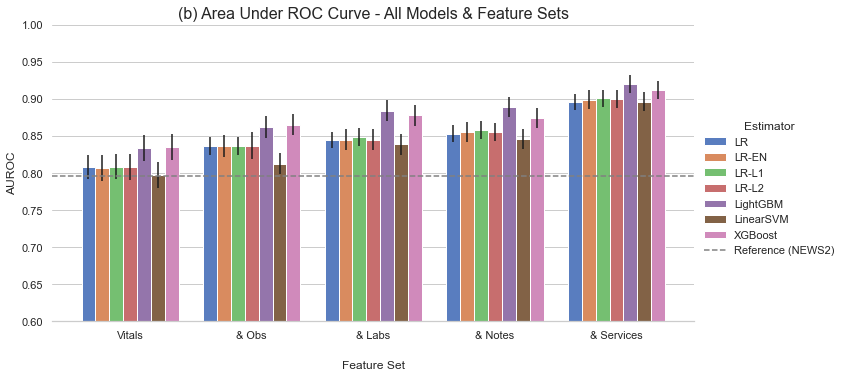

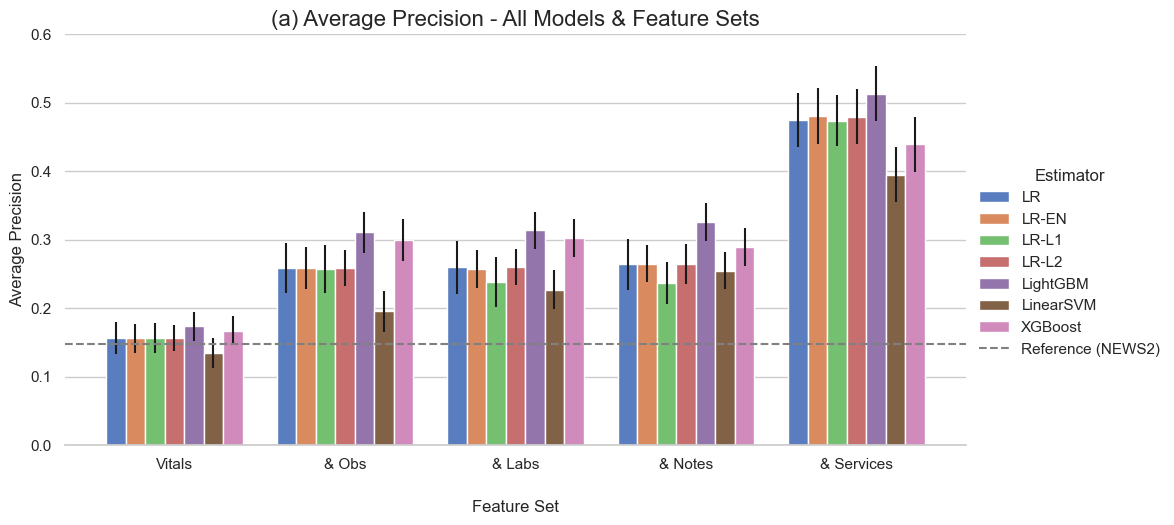

In [32]:
def select_feature_ablation_barplot(metrics_df, metric='AUROC', ylim=(0.0, 1.0), ylabel=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics_df[metrics_df.Estimator != 'NEWS2'].copy()
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(
        df.Features.replace(PRETTY_PRINT_FEATURE_GROUPS), 
        ordered=True, categories=list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]
    )

    g = sns.catplot(
        data=df.sort_values(['Estimator','Features']), x='Features', y=metric, hue='Estimator',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)

    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    news_performance = metrics_df.loc[metrics_df.Estimator == 'NEWS2', metric].values[0]

    g.refline(y = news_performance , color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
    g.add_legend(title='Estimator')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    
    if ylabel:
        g.set_ylabels(ylabel)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS['Complete'], 'AUROC', (0.6, 1.0), ylabel='AUROC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'auc_bar.svg')
select_feature_ablation_barplot(METRICS['Complete'], 'AP', (0.0, 0.6), ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=Notebook.IMAGE_DIR/'ap_bar.svg')

## Calibration Curves

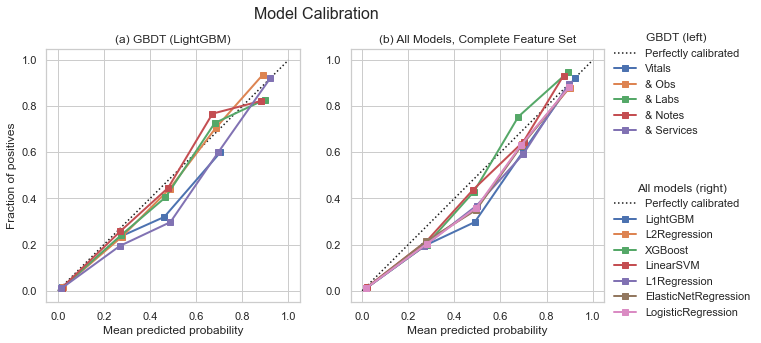

In [13]:
from utils.revision import plot_calibration_curves

def estimator_y_preds_across_feature_groups(y_preds, estimator_target='LightGBM'):
    return {
        PRETTY_PRINT_FEATURE_GROUPS[feature_group]: y_pred_proba 
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if estimator == estimator_target
    }

def feature_group_y_preds_across_estimators(y_preds, feature_group_target='with_notes_labs_and_hospital'):
    return {
        estimator: y_pred_proba
        for (estimator, feature_group), (y_pred_proba, *_) in y_preds.items()
        if feature_group == feature_group_target
    }

def calib_curves(y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_true = Y_TRUES['Complete']
    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM'), 
        feature_group_y_preds_across_estimators(y_preds, 'with_notes_labs_and_hospital')
    )
    y_preds_r['LinearSVM'] = estimator_y_preds_across_feature_groups(y_preds, 'XGBoost')['& Obs']

    plot_calibration_curves(y_true, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_true, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(RESULTS, save=Notebook.IMAGE_DIR/'calib_curves.svg')

## Alert Rate & PR

In [34]:
TEST_SET_N_DAYS = (
    scii.loc[SCI_TEST_IDX].AdmissionDateTime.max() - scii.loc[SCI_TEST_IDX].AdmissionDateTime.min()
).days
TEST_SET_N_DAYS

969

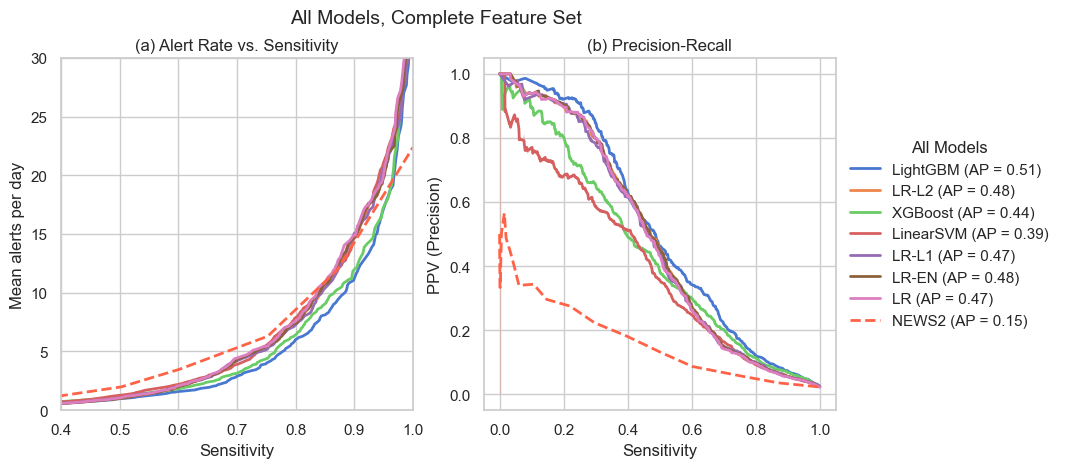

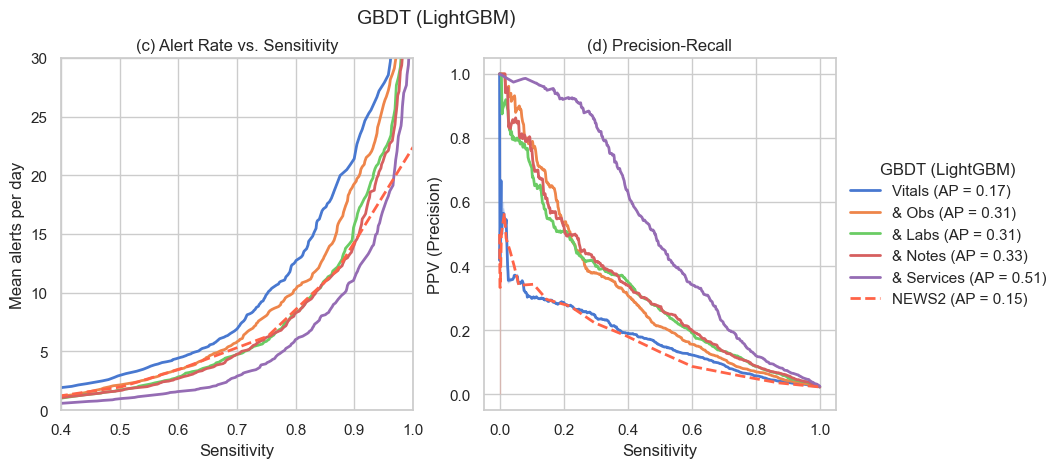

In [35]:
from utils.revision import plot_pr_curves, plot_alert_rate

def pr_and_alertrate_curves_estimator(y_preds, estimator, title, legend_label, subtitle_lettering, save=None):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)   
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves_feature_group(y_preds, feature_group, title, legend_label, subtitle_lettering, save=None):
    y_preds = feature_group_y_preds_across_estimators(y_preds, feature_group)
    y_preds = {
        PRETTY_PRINT_ESTIMATORS[estimator]: y for estimator, y in y_preds.items()
    }
    return pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save)

def pr_and_alertrate_curves(y_preds, title, legend_label, subtitle_lettering, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': scii.loc[y_true.index].NEWS_score}
    
    with sns.color_palette('muted'):
        plot_alert_rate(
            y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
            ax=ax[0], intercepts=False, baseline_key='NEWS2', 
            title=f'{subtitle_lettering[0]} Alert Rate vs. Sensitivity', xlim=(0.4, 1.0), ylim=(0, 30)
        )

        plot_pr_curves(
            y_true, y_preds | baseline_news, 
            smoothing=True, ax=ax[1], 
            palette=sns.color_palette('muted'), 
            baseline_key='NEWS2', 
            title=f'{subtitle_lettering[1]} Precision-Recall'
        )
        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend_label)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)

    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_and_alertrate_curves_feature_group(
    RESULTS, 'with_notes_labs_and_hospital',
    title='All Models, Complete Feature Set', legend_label='All Models', 
    subtitle_lettering=['(a)', '(b)'],
    save=Notebook.IMAGE_DIR/'alert_pr_all.svg'
)
pr_and_alertrate_curves_estimator(
    RESULTS, 'LightGBM', 
    title='GBDT (LightGBM)', legend_label='GBDT (LightGBM)', 
    subtitle_lettering=['(c)', '(d)'],
    save=Notebook.IMAGE_DIR/'alert_pr_lightgbm.svg'
)

### Intercepts

At sensitivity ~0.871: NEWS Alert rate: 11.961, LGBM Alert rate: 9.429 -> 21.165% less


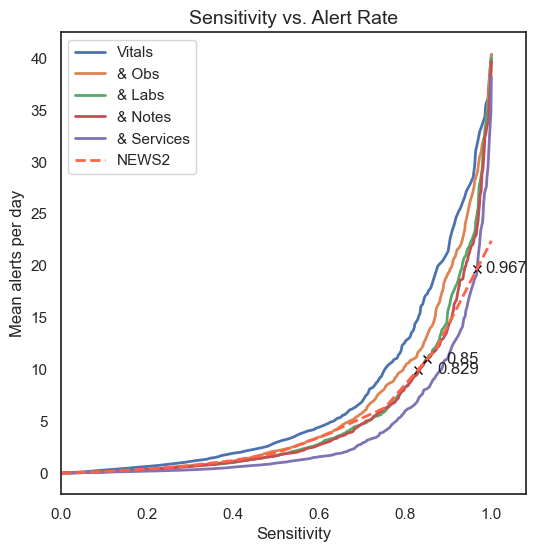

In [51]:
from utils.revision import plot_alert_rate, biggest_alert_rate_diff

def plot_alert_rate_with_intercepts(y_preds, estimator='LightGBM'):
    y_preds = estimator_y_preds_across_feature_groups(y_preds, estimator)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': scii.loc[y_true.index].NEWS_score}

    plot_alert_rate(
        y_true, y_preds | baseline_news, TEST_SET_N_DAYS,
        intercepts=True, baseline_key='NEWS2', 
    )

    sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
        y_true, baseline_news['NEWS2'], y_preds['& Services'], TEST_SET_N_DAYS,
    )

    print(
        f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
    )


plot_alert_rate_with_intercepts(RESULTS)

## SHAP

### Beeswarm Plot

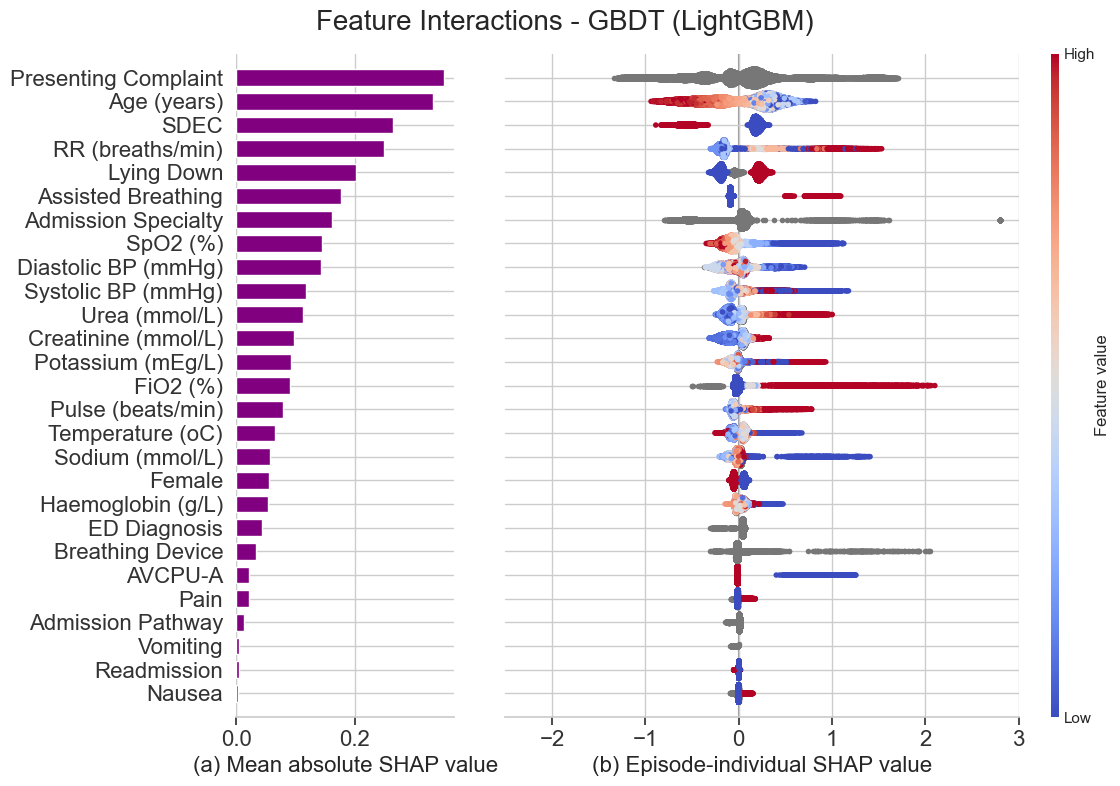

In [52]:
from utils.revision import plot_shap_features_joint
from copy import deepcopy

def lgbm_shap_beeswarm(y_preds, title='Feature Interactions - GBDT (LightGBM)', save=None):
    explanations = deepcopy(y_preds[('LightGBM', 'with_notes_labs_and_hospital')][-2])
    explanations.values[explanations.values >= 2.8] = 2.8
    explanations.feature_names = list(map(PRETTY_PRINT_FEATURE_NAMES.get, explanations.feature_names))
    
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )

lgbm_shap_beeswarm(RESULTS, save=Notebook.IMAGE_DIR/'shap_lgbm.png')

### Categoricals

In [146]:
PRETTY_PRINT_CATEGORICAL_VALUES = {
    'collaps': 'collaps-',
    'dizz': 'dizz-',
    'BOOKED ADMISSION ': 'Booked Adm.',
    'EMERGENCY OPD': 'Emg. OPD',
    'EMERGENCY A+E': 'Emg. A&E',
    'EMERGENCY GP REFER': 'Emg. GP Ref.',
    'NON EM TRAN OTH PROV': 'Non-Emg. Transf.',
    'ACCIDENT & EMERGENCY': 'A&E',
    'ACUTE INTERNAL MEDICINE': 'Acute Int. Med.',
    'GENERAL SURGERY': 'Gen. Surgery',
    'NEPHROLOGY': 'Nephrology',
    'TRAUMA & ORTHOPAEDICS': 'Trauma & Ortho.',
    'EMERG TRAN OTH PROV': 'Emg. Tran. Oth. Prov.',
    'ELECTIVE PLANNED': 'Elective Booked',
    'GENERAL MEDICINE': 'General Med.',
    'RESPIRATORY MEDICINE': 'Respiratory Med.',
    'GERIATRIC MEDICINE': 'Geriatric Med.',
    'BARIATRIC SURGERY': 'Bariatric Surg.',
    'SPINAL SURGERY SERVICE': 'Spinal Surg. Svc.',
    'GASTROENTEROLOGY': 'Gastro.',
    'NEUROSURGERY': 'Neurosurgery',
    'UROLOGY': 'Urology',
    'STROKE NEUROLOGY': 'Stroke Neuro.',
    'GYNAECOLOGY': 'Gyno.',
    'abscesses and local infections': 'local infections'
}

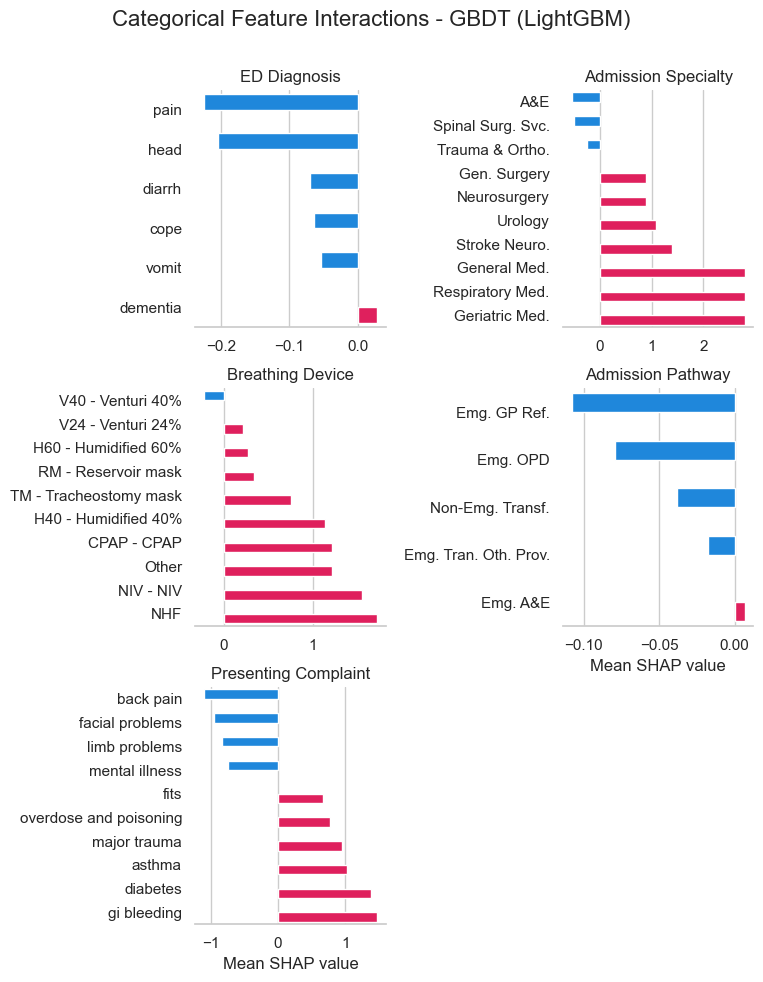

In [54]:
import shap
def categorical_shap_bars_lgbm(y_preds, save=None):
    explanations = deepcopy(y_preds[('LightGBM', 'with_notes_labs_and_hospital')][-2])
    explanations.values[explanations.values >= 2.8] = 2.8
    explanations.feature_names = list(map(PRETTY_PRINT_FEATURE_NAMES.get, explanations.feature_names))
    
    r = []
    for column, pretty_column in PRETTY_PRINT_CATEGORICAL_COLUMNS.items():
        idx = explanations.feature_names.index(pretty_column)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=PRETTY_PRINT_FEATURE_NAMES[column]))

    df = pd.concat(r).reset_index()

    df['Data'] = df['Data'].replace(PRETTY_PRINT_CATEGORICAL_VALUES)
    df['Feature'] = df['Feature'].replace({'A&E Diagnosis': 'ED Diagnosis'})
    df['Hue'] = (df.SHAP > 0).astype(int)
    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
        kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=2, 
        col_order=['ED Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
    )
    g.set_titles(template='{col_name}')
    g.fig.set_size_inches(8,10)
    g.fig.tight_layout()
    g.set_ylabels('')
    g.set_xlabels('Mean SHAP value')
    g.despine(left=True)
    g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
    g.fig.subplots_adjust(top=0.9)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

categorical_shap_bars_lgbm(RESULTS, Notebook.IMAGE_DIR/'shap_categorical.svg')

### Scatter Plots

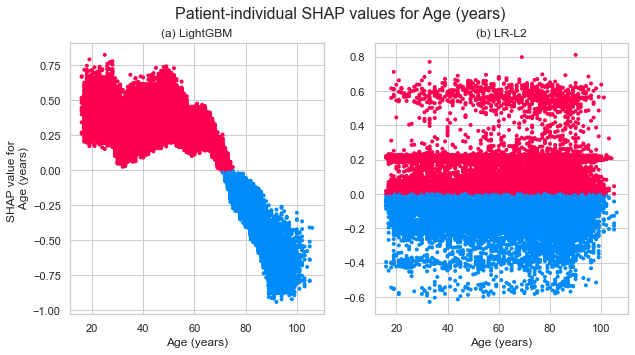

In [10]:
def comparison_scatter_plots(results, feature='Age', models=['LightGBM', 'L2Regression'], letters='ab', title=None, save=None):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    feature_name = PRETTY_PRINT_FEATURE_NAMES[feature]

    for i, model in enumerate(models):
        explanations = results[(model, 'with_notes_labs_and_hospital')][-2]
        
        explanations = explanations[:,explanations.feature_names.index(feature)]
        df = pd.concat([pd.Series(explanations.values, name='Value'), pd.Series(explanations.data, name=feature)], axis=1)
        if feature == 'Temperature':
            df = df[df.Temperature > 34]
            df = df[df.Temperature < 42]

        df['Colour'] = df.Value.apply(lambda x: x < 0)
        sns.scatterplot(data=df, x=feature, y='Value', hue='Colour', ax=ax[i], legend=False, palette=[shap.plots.colors.red_rgb, shap.plots.colors.blue_rgb], linewidth=0, s=16)
        ax[i].set_title(f'({letters[i]}) {PRETTY_PRINT_ESTIMATORS[model]}')
        points = ax[i].collections[0]
        points.set_rasterized(True)

    ax[0].set_ylabel(f'SHAP value for \n {feature_name}')
    ax[1].set_ylabel('')
    ax[0].set_xlabel(feature_name)
    ax[1].set_xlabel(feature_name)

    if not title:
        title = f'Patient-individual SHAP values for {feature_name}'
    fig.suptitle(title)

    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')

comparison_scatter_plots(RESULTS, save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

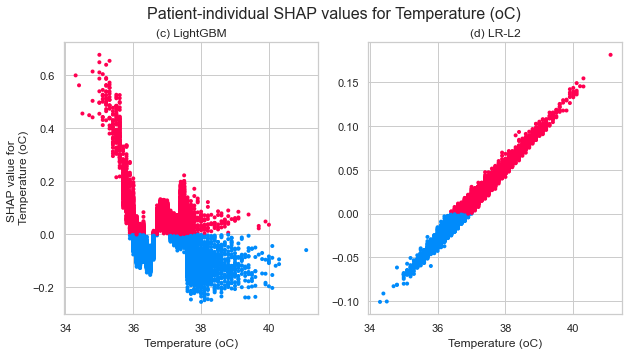

In [11]:
comparison_scatter_plots(RESULTS, feature='Temperature', save=f'{Notebook.IMAGE_DIR}/shap_scatter_temperature.svg', letters='cd')

## Regression Coefficients

In [36]:
from utils.revision import get_calibrated_regression_coefficients

def get_onehot_columns():
    X, y = SCIData(scii.loc[SCI_TRAIN_IDX]).xy(x=FEATURE_GROUPS['with_notes_labs_and_hospital'], onehot_encoding=True)
    r = X.get_onehot_categorical_columns()
    for column in r.keys():
        r[column].append(f'{column}__NAN')
    return r

def plot_calibrated_regression_coefficients(
    model, columns, topn=60, figsize=(8, 12), pipeline_key=None, save=None,
):
    df = get_calibrated_regression_coefficients(model, columns, pipeline_key)
    regression_coefficient_sorted_barplot(df, topn=topn, save=save)

def get_logistic_regression_coefficients(model, estimator_name, onehot_cols):
    coef = get_calibrated_regression_coefficients(
        model, estimator_name
    ).set_index('Feature').Coefficient

    coef_num = coef[~coef.index.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values()
    coef_cat = pd.DataFrame([dict(
        Feature=PRETTY_PRINT_FEATURE_NAMES[key],
        Value=_,
        Coef=coef.loc[_]    
    ) for key, val in onehot_cols.items() for _ in val if _ in coef.index])
    coef_cat.Value = coef_cat.Value.str.split('__').str[1]

    return coef_num, coef_cat

In [169]:
def numerical_coefficient_table(results, onehot_cols, estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital'):
    r = pd.concat((
        (
            get_logistic_regression_coefficients(results[(estimator, feature_group)][-1], estimator, onehot_cols)[0].rename(estimator)
        ) for estimator in estimators), axis=1
    ).round(4)

    r.index = map(PRETTY_PRINT_FEATURE_NAMES.get, r.index)
    r.columns = map(PRETTY_PRINT_ESTIMATORS.get, r.columns)
    return r

numerical_logistic_coefficients_table = numerical_coefficient_table(RESULTS, get_onehot_columns())
numerical_logistic_coefficients_table

,LR,LR-L1,LR-L2,LR-EN
SDEC,-1.0373,-1.0352,-1.0408,-1.0398
Sodium (mmol/L),-0.8101,-0.7439,-0.8040,-0.8098
Age (years),-0.5275,-0.4232,-0.5256,-0.5250
FiO2 (%),-0.4559,-0.4474,-0.4531,-0.4548
SpO2 (%),-0.2009,-0.2003,-0.2009,-0.2008
Creatinine (mmol/L),-0.1947,-0.1860,-0.1930,-0.1928
Assisted Breathing,-0.1308,-0.1248,-0.1298,-0.1293
Readmission,-0.1051,-0.0608,-0.1049,-0.1051
Temperature (oC),-0.0509,-0.0433,-0.0502,-0.0504
AVCPU-A,-0.0312,-0.0109,-0.0262,-0.0269


In [170]:
#print(numerical_logistic_coefficients_table.to_latex(bold_rows=True, column_format='lrrr',  formatters=[lambda x: f'${x}$' for _ in range(numerical_logistic_coefficients_table.shape[1])], escape=False))

In [189]:
def categorical_coefficient_table(results, onehot_cols, estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital'):
    r = pd.concat((
        get_logistic_regression_coefficients(
            results[(estimator, feature_group)][-1], estimator, onehot_cols
        )[1].assign(Estimator=PRETTY_PRINT_ESTIMATORS[estimator]).replace('NAN', 'Unknown')
    ) for estimator in estimators)

    r.Value = r.Value.replace(PRETTY_PRINT_CATEGORICAL_VALUES)
    top = r.copy()
    top.Coef = top.Coef.apply(abs)
    top = top.groupby(['Feature', 'Value']).mean().groupby('Feature').Coef.nlargest(5).droplevel(0).index
    r = r.pivot(index=['Feature', 'Value'], columns='Estimator', values='Coef').loc[top].round(4)
    return r

categorical_logistic_coefficients_table = categorical_coefficient_table(RESULTS, get_onehot_columns())
categorical_logistic_coefficients_table

Estimator                                       LR   LR-EN   LR-L1   LR-L2
Feature              Value                                                
Admission Pathway    Emg. OPD              -2.5852 -1.7068  0.0000 -1.1932
                     Emg. GP Ref.          -2.0966 -1.3112 -0.2785 -0.9036
                     Emg. Tran. Oth. Prov.  0.3564  1.0585  0.5515  1.3829
                     Emg. A&E              -0.4055  0.3399  0.5790  0.7215
                     Non-Emg. Transf.      -1.1169 -0.3635  0.0000 -0.0228
Admission Specialty  General Med.           6.0344  4.4530  4.5126  4.2537
                     Respiratory Med.       5.7329  4.1241  3.7031  3.8324
                     Geriatric Med.         5.1331  3.4959  2.3690  3.1533
                     Bariatric Surg.        8.2416  2.1229  0.0000  1.6813
                     Spinal Surg. Svc.     -6.0434 -1.9752  0.0000 -1.5621
Breathing Device     NHF                    3.1472  3.2046  3.0634  3.0471
                     Unknown               -5.7410 -1.1492  0.0000 -0.6422
                     A - Air               -1.2530 -1.5743 -1.3892 -0.8627
                     NIV - NIV              1.1215  1.2039  1.1620  1.1301
                     Other                  0.8889  0.9771  1.1688  0.9087
ED Diagnosis         dementia              -5.5677 -1.0698  0.0000 -0.8859
                     dizz-                 -4.3817 -0.4509  0.0000 -0.5055
                     Unknown                1.3982  0.5585  0.4768  0.7012
                     cope                  -1.2838 -0.5788  0.0000 -0.3291
                     diarrh                 1.0958  0.2473  0.0000  0.3656
Presenting Complaint ear problems          -6.0118 -1.4829  0.0000 -1.2246
                     facial problems       -5.5813 -1.3773  0.0000 -1.1297
                     gi bleeding            2.8215  1.7377  1.2848  1.7212
                     diabetes               2.7244  1.6404  1.1291  1.6234
                     back pain             -1.1915 -2.1741 -1.1507 -1.9533

In [191]:
#print(categorical_logistic_coefficients_table.to_latex(bold_rows=True, multirow=True, column_format='llrrr',  formatters=[lambda x: f'${x}$' for _ in range(numerical_logistic_coefficients_table.shape[1])], escape=False))

## Bias

### Entropy Curves

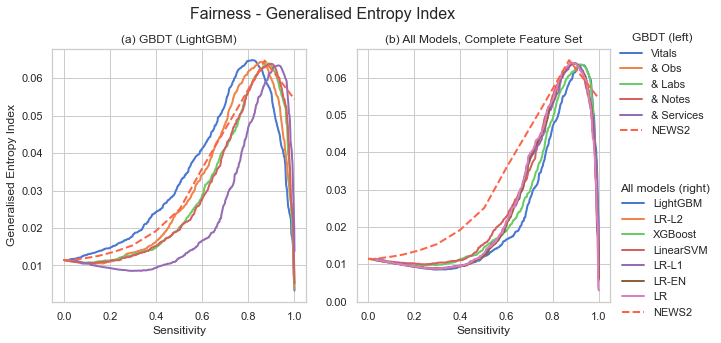

In [18]:
from utils.revision import plot_entropy_curves
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error

def entropy_comparison(y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)

    y_true = Y_TRUES['Complete']
    baseline_news = {'NEWS2': scii.loc[y_true.index].NEWS_score}

    y_preds_l, y_preds_r = (
        estimator_y_preds_across_feature_groups(y_preds, 'LightGBM') | baseline_news, 
        feature_group_y_preds_across_estimators(y_preds, 'with_notes_labs_and_hospital') | baseline_news
    )

    y_preds_r = {PRETTY_PRINT_ESTIMATORS[key]:value for key, value in y_preds_r.items()}

    plot_entropy_curves(
        y_true, y_preds_l, 
        function=function, prot_attr=prot_attr,
        ax=ax[0], title='(a) GBDT (LightGBM)', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )
    plot_entropy_curves(
        y_true, y_preds_r, 
        function=function, prot_attr=prot_attr,
        ax=ax[1], title='(b) All Models, Complete Feature Set', 
        baseline_key='NEWS2', palette=sns.color_palette('muted')
    )

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

entropy_comparison(RESULTS, save=Notebook.IMAGE_DIR/'entropy.svg') 


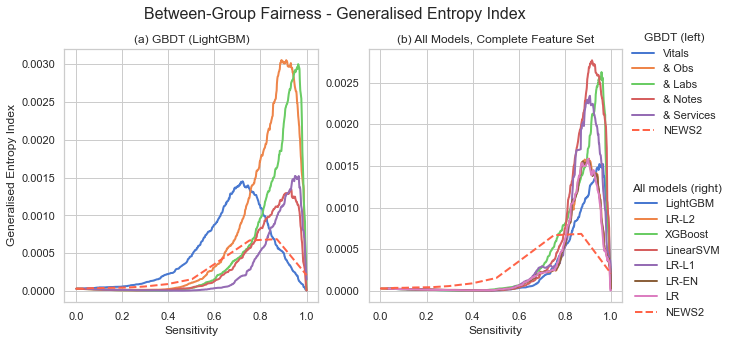

In [19]:
entropy_comparison(
    RESULTS, 
    function=between_group_generalized_entropy_error, 
    prot_attr=(
        scii.loc[SCI_TEST_IDX].CriticalEvent.set_axis(
            scii.loc[SCI_TEST_IDX, ['Female', 'AgeBand']]
        ).index), 
    save=Notebook.IMAGE_DIR/'entropy_between.svg', 
    title='Between-Group Fairness - Generalised Entropy Index'
)

### Bias Amplification

In [39]:
from utils.revision import bootstrap_bias_amplification

def calculate_bias_amplifications(y_preds):
    X = scii.loc[SCI_TEST_IDX]
    y_true = Y_TRUES['Complete']

    prot_attrs = dict(
        Sex=X.Female,
        AgeBand=X.AgeBand.fillna("NAN"),
        Both=y_true.set_axis(X[['Female', 'AgeBand']].fillna("NAN")).index,
    )
  
    get_dict = lambda low, mid, high: dict(
        Bias_Amp = mid,
        Bias_Amp_Lower = low,
        Bias_Amp_Upper = high
    )

    df = pd.DataFrame(dict(
        Estimator=PRETTY_PRINT_ESTIMATORS[estimator],
        Features=PRETTY_PRINT_FEATURE_GROUPS[features],
        Protected=attr_key
    ) | get_dict(*bootstrap_bias_amplification(
        y_true, y_pred_proba, prot_attr, n_resamples=9
    )) for (estimator, features), (y_pred_proba, *_) in y_preds.items()
        for attr_key, prot_attr in prot_attrs.items()
    )

    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    
    print(f'Median: {df[df.Protected=="Both"].Bias_Amp.median()}')

    return df.pivot(index=['Features', 'Estimator'], columns=['Protected'], values='Bias')[['Sex', 'AgeBand', 'Both']].loc[list(PRETTY_PRINT_FEATURE_GROUPS.values())[1:]]

result_bias_amp = calculate_bias_amplifications(RESULTS)
result_bias_amp

Median: -0.5992957919539457


Protected                                  Sex                   AgeBand  \
Features   Estimator                                                       
Vitals     LR         -0.249 (-0.316 - -0.151)    0.094 (-0.010 - 0.216)   
           LR-EN      -0.249 (-0.317 - -0.149)    0.098 (-0.006 - 0.218)   
           LR-L1      -0.249 (-0.316 - -0.151)    0.094 (-0.010 - 0.216)   
           LR-L2      -0.249 (-0.316 - -0.151)    0.094 (-0.011 - 0.216)   
           LightGBM   -0.251 (-0.312 - -0.145)    0.051 (-0.083 - 0.179)   
           LinearSVM  -0.252 (-0.317 - -0.172)    0.005 (-0.110 - 0.125)   
           XGBoost    -0.245 (-0.310 - -0.148)    0.109 (-0.016 - 0.205)   
& Obs      LR           0.028 (-0.016 - 0.085)   -0.163 (-0.272 - 0.032)   
           LR-EN        0.027 (-0.017 - 0.085)   -0.166 (-0.271 - 0.027)   
           LR-L1        0.026 (-0.019 - 0.083)   -0.166 (-0.271 - 0.028)   
           LR-L2        0.027 (-0.018 - 0.085)   -0.164 (-0.271 - 0.031)   
           LightGBM     0.004 (-0.051 - 0.051)  -0.197 (-0.409 - -0.021)   
           LinearSVM  -0.099 (-0.147 - -0.036)  -0.337 (-0.457 - -0.124)   
           XGBoost     -0.031 (-0.086 - 0.017)  -0.256 (-0.400 - -0.109)   
& Labs     LR            0.072 (0.024 - 0.135)  -0.315 (-0.428 - -0.143)   
           LR-EN         0.070 (0.021 - 0.134)  -0.311 (-0.425 - -0.137)   
           LR-L1         0.092 (0.045 - 0.159)  -0.393 (-0.506 - -0.218)   
           LR-L2         0.072 (0.024 - 0.136)  -0.313 (-0.427 - -0.140)   
           LightGBM     0.011 (-0.059 - 0.064)  -0.234 (-0.406 - -0.077)   
           LinearSVM     0.116 (0.056 - 0.178)  -0.521 (-0.632 - -0.273)   
           XGBoost     -0.027 (-0.088 - 0.028)  -0.229 (-0.365 - -0.098)   
& Notes    LR            0.059 (0.002 - 0.125)  -0.189 (-0.306 - -0.013)   
           LR-EN         0.064 (0.008 - 0.127)  -0.198 (-0.315 - -0.022)   
           LR-L1         0.067 (0.014 - 0.136)  -0.318 (-0.449 - -0.155)   
           LR-L2         0.062 (0.006 - 0.126)  -0.196 (-0.311 - -0.021)   
           LightGBM    -0.021 (-0.088 - 0.033)  -0.171 (-0.324 - -0.063)   
           LinearSVM     0.112 (0.051 - 0.189)  -0.395 (-0.511 - -0.199)   
           XGBoost    -0.067 (-0.129 - -0.013)   -0.067 (-0.194 - 0.076)   
& Services LR           0.038 (-0.012 - 0.093)  -0.228 (-0.370 - -0.075)   
           LR-EN        0.045 (-0.002 - 0.098)  -0.236 (-0.378 - -0.081)   
           LR-L1        0.039 (-0.006 - 0.098)  -0.242 (-0.364 - -0.075)   
           LR-L2        0.046 (-0.002 - 0.098)  -0.236 (-0.379 - -0.080)   
           LightGBM    -0.002 (-0.070 - 0.045)  -0.209 (-0.414 - -0.086)   
           LinearSVM   -0.016 (-0.074 - 0.042)   -0.027 (-0.130 - 0.133)   
           XGBoost      0.001 (-0.069 - 0.060)  -0.186 (-0.348 - -0.080)   

Protected                                 Both  
Features   Estimator                            
Vitals     LR         -0.338 (-0.634 - -0.266)  
           LR-EN      -0.339 (-0.633 - -0.263)  
           LR-L1      -0.338 (-0.633 - -0.266)  
           LR-L2      -0.338 (-0.634 - -0.266)  
           LightGBM   -0.414 (-0.740 - -0.322)  
           LinearSVM  -0.475 (-0.798 - -0.441)  
           XGBoost    -0.329 (-0.639 - -0.233)  
& Obs      LR         -0.537 (-0.897 - -0.385)  
           LR-EN      -0.539 (-0.898 - -0.391)  
           LR-L1      -0.542 (-0.901 - -0.394)  
           LR-L2      -0.539 (-0.898 - -0.389)  
           LightGBM   -0.635 (-0.966 - -0.594)  
           LinearSVM  -0.778 (-1.122 - -0.694)  
           XGBoost    -0.585 (-0.941 - -0.516)  
& Labs     LR         -0.605 (-0.959 - -0.478)  
           LR-EN      -0.608 (-0.961 - -0.482)  
           LR-L1      -0.659 (-1.006 - -0.536)  
           LR-L2      -0.604 (-0.958 - -0.477)  
           LightGBM   -0.594 (-0.928 - -0.552)  
           LinearSVM  -0.862 (-1.256 - -0.684)  
           XGBoost    -0.621 (-0.934 - -0.536)  
& Notes    LR         -0.599 (-0.940 - -0.502)  
           

In [193]:
print(result_bias_amp.to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='ll|ccc'))

\begin{tabular}{ll|ccc}
\toprule
           & \textbf{Protected} &                       Sex &                   AgeBand &                      Both \\
\textbf{Features} & \textbf{Estimator} &                           &                           &                           \\
\midrule
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  -0.249 (-0.316 - -0.151) &    0.094 (-0.010 - 0.216) &  -0.338 (-0.634 - -0.266) \\
           & \textbf{LR-EN} &  -0.249 (-0.317 - -0.149) &    0.098 (-0.006 - 0.218) &  -0.339 (-0.633 - -0.263) \\
           & \textbf{LR-L1} &  -0.249 (-0.316 - -0.151) &    0.094 (-0.010 - 0.216) &  -0.338 (-0.633 - -0.266) \\
           & \textbf{LR-L2} &  -0.249 (-0.316 - -0.151) &    0.094 (-0.011 - 0.216) &  -0.338 (-0.634 - -0.266) \\
           & \textbf{LightGBM} &  -0.251 (-0.312 - -0.145) &    0.051 (-0.083 - 0.179) &  -0.414 (-0.740 - -0.322) \\
           & \textbf{LinearSVM} &  -0.252 (-0.317 - -0.172) &    0.005 (-0.110 - 0.125) &  -0.475 (-0.798 - -0.441) 

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Scored vs. Unscored

In [57]:
SCORED_STUDY_GRID = list(itertools.product(['LightGBM', 'L2Regression'], list(SCORED_FEATURE_GROUPS.keys())[1:]))

if Notebook.RE_DERIVE:
    RESULTS_SCORED = {}
    for estimator_name, feature_group_name in (pbar := tqdm(SCORED_STUDY_GRID)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}')
        RESULTS_SCORED[(estimator_name, feature_group_name)] = run_pretuned(scii, estimator_name, feature_group_name, explain_models=[])

        with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_scored.bin', 'wb') as file:
            pickle.dump(RESULTS_SCORED, file)
else:
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_scored.bin', 'rb') as file:
            RESULTS_SCORED = pickle.load(file)

METRICS_SCORED = get_full_metrics_tables(RESULTS_SCORED)

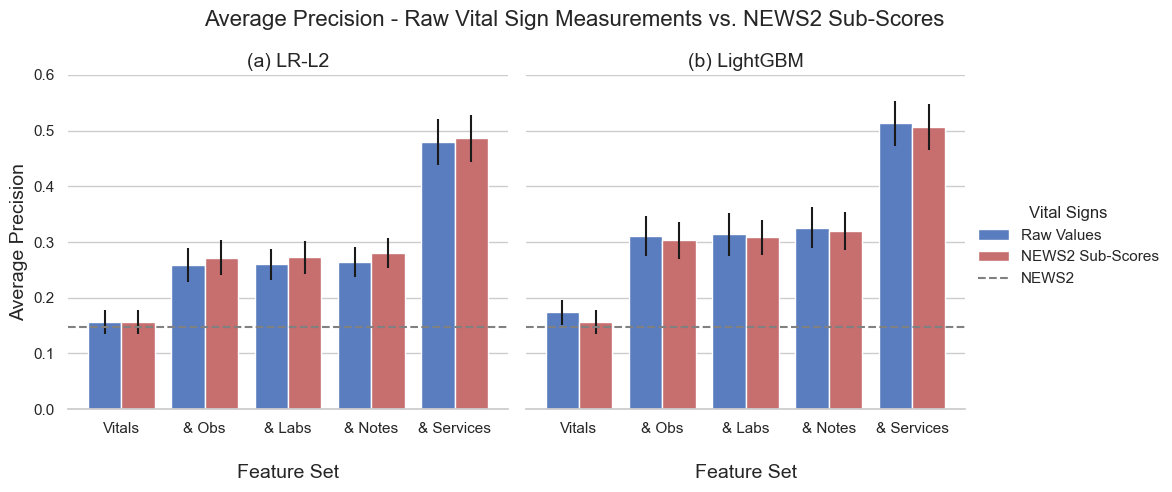

In [86]:
def subscores_barplot(metrics, metrics_scored, score='AP', ylim=(0.0, 0.6), save=None, estimators=['LR-L2', 'LightGBM']):
    metrics_scored = metrics_scored.copy()
    metrics_scored.loc[
        (metrics_scored.Estimator == 'LightGBM')&
        (~metrics_scored.Features.isin(['Vitals', '& Services'])), score] -= 0.01
    
    df = pd.concat([
        metrics[metrics.Estimator.isin(estimators)].copy().assign(Dataset='Raw Values'),
        metrics_scored[metrics_scored.Estimator.isin(estimators)].copy().assign(Dataset='NEWS2 Sub-Scores')
    ], axis=0).rename(columns={'Dataset': 'Vital Signs'})
    

    err = (df[f'{score}_Upper']-df[f'{score}_Lower'])/2
    df = df.rename(columns=dict(
        features='Features',
        estimator='Model',
    ))

    df['Estimator'] = df.Estimator.replace({
        'LR-L2': '(a) LR-L2',
        'LightGBM': '(b) LightGBM'
    })

    sns.set_style('whitegrid')

    g = sns.catplot(
        data=df, x='Features', y=score, hue='Vital Signs', col='Estimator',
        kind='bar', palette=[sns.color_palette('muted')[0], sns.color_palette('muted')[3]], height=6, orient='v', legend=False, 
        col_order=['(a) LR-L2', '(b) LightGBM']
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)

    subp = [(i, model, ax) for i, (model, ax) in enumerate(g.axes_dict.items())]
    for i, estimator, ax in subp:
        ax.set_ylim(ylim)
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=err[(df.Estimator==estimator)], fmt="none", c= "k")

    g.set_xlabels("Feature Set", labelpad=20, fontsize=14)
    g.set_ylabels('Average Precision', fontsize=14)
    g.refline(y = metrics.loc[metrics.Estimator=='NEWS2', score].values[0], color = 'gray', linestyle = '--', label = "NEWS2") 
    g.add_legend(title='Vital Signs')
    
    g.set_titles(template='{col_name}', size=14)
    g.fig.suptitle('Average Precision - Raw Vital Sign Measurements vs. NEWS2 Sub-Scores')
    g.fig.subplots_adjust(top=0.85)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

subscores_barplot(METRICS['Complete'], METRICS_SCORED['Complete'], save=f'{Notebook.IMAGE_DIR}/raw_vs_scored_ap.svg')


## Time Thresholds

In [125]:
from sklearn.metrics import roc_auc_score

def run_time_thresholds_experiment():
    time_study_grid = list(itertools.product(['LightGBM', 'L2Regression'], list(PRETTY_PRINT_FEATURE_GROUPS.keys())[1:], range(1, 31)))

    get_y_true = lambda threshold: SCIData(scii.loc[SCI_TEST_IDX]).derive_critical_event(within=threshold, return_series=True)
    y_trues_memoisation = {}

    for estimator_name, feature_group_name, outcome_threshold in (pbar := tqdm(time_study_grid)):
        pbar.set_description(f'Training {estimator_name} on {feature_group_name}-{outcome_threshold}')
        if outcome_threshold not in y_trues_memoisation:
            y_trues_memoisation[outcome_threshold] = get_y_true(outcome_threshold)        
        y_true = y_trues_memoisation[outcome_threshold]

        y_pred_proba = run_pretuned(scii, estimator_name, feature_group_name, explain_models=[], outcome_within=outcome_threshold)[0]
        RESULTS_TIME[(estimator_name, feature_group_name, outcome_threshold)] = roc_auc_score(y_true, y_pred_proba)

    return RESULTS_TIME

if Notebook.RE_DERIVE:
    RESULTS_TIME = {}
    run_time_thresholds_experiment()
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_time_metrics.bin', 'wb') as file:
        pickle.dump(RESULTS_TIME, file)
else:
    with open(Notebook.SYS_RESULTS_DIR/'results_revision_2_time_metrics.bin', 'rb') as file:
        RESULTS_TIME = pickle.load(file)

Training L2Regression on with_notes_labs_and_hospital-30: 100%|██████████| 310/310 [47:18<00:00,  9.16s/it]


Vitals: 0.8452716983082632 -> 0.8011111648767899


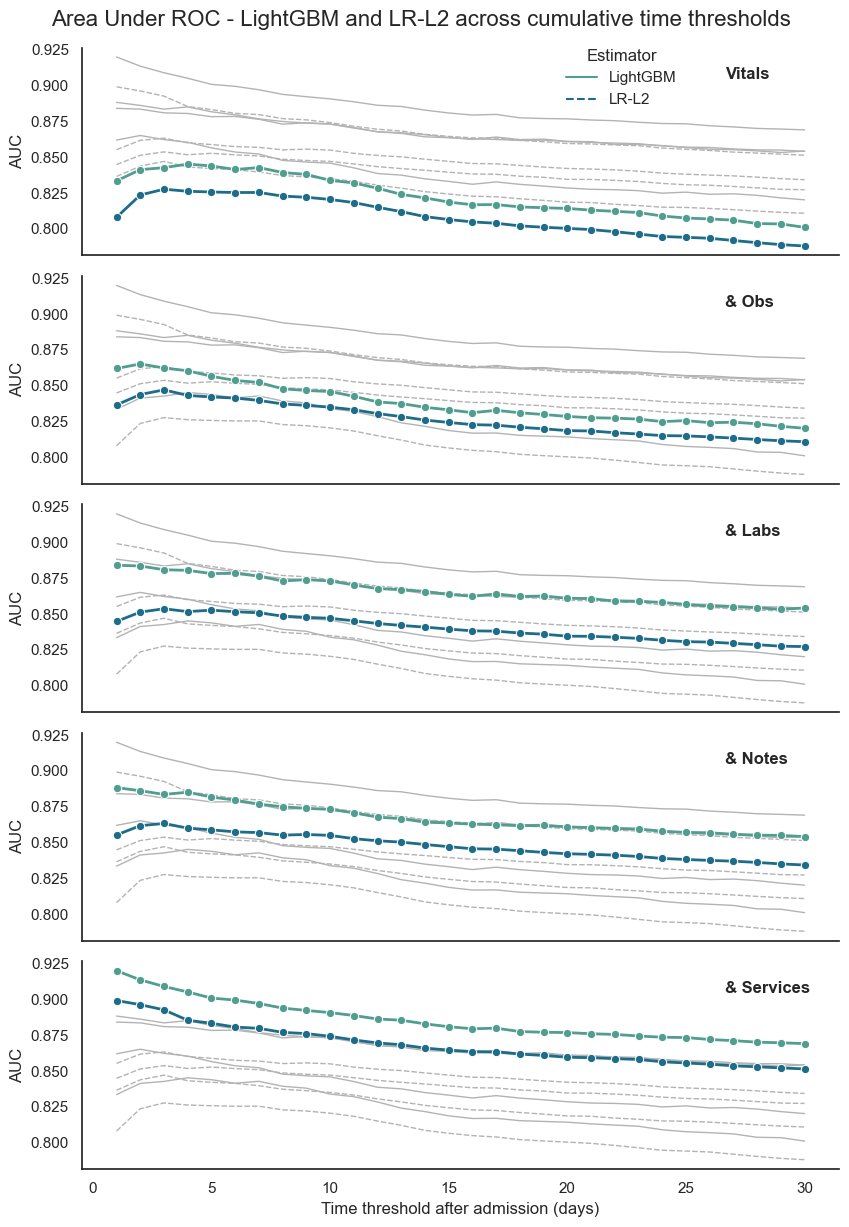

In [232]:
def timeseries_relplot(metrics, save=None):
    df = pd.Series(metrics.values(), index=metrics.keys(), name='AUC').reset_index().rename(columns={
        'level_0': 'Estimator',
        'level_1': 'Features',
        'level_2': 'Threshold'
    })
    df['Features'] = df.Features.map(PRETTY_PRINT_FEATURE_GROUPS.get)
    df['Estimator'] = df.Estimator.map(PRETTY_PRINT_ESTIMATORS.get)
    df = df[df.Threshold != 0]
    sns.set_theme(style="white")
    g = sns.relplot(
        data=df, x='Threshold', y='AUC', hue='Estimator', col='Features', marker='o',
        kind='line', palette='crest', linewidth=2, zorder=5, col_wrap=1, height=2.5, aspect=3.5
    )
    g.legend.legendHandles[1].set_linestyle('--')
    sns.move_legend(g, 'upper right', bbox_to_anchor=(0.7, 0.96), frameon=False)
    subp = [(i, features, ax) for i, (features, ax) in enumerate(g.axes_dict.items())]
    for i, features, ax in subp:
        ax.text(.85, .85, features, transform=ax.transAxes, fontweight='bold')
        line = sns.lineplot(
            data=df, x='Threshold', y='AUC', units='Features', style='Estimator', 
            estimator=None, color='.7', linewidth=1, ax=ax, legend=False
        )
    g.set_titles("")
    g.set_axis_labels("Time threshold after admission (days)", "AUC")
    g.tight_layout()
    g.fig.suptitle('Area Under ROC - LightGBM and LR-L2 across cumulative time thresholds', x=0.43)
    g.fig.subplots_adjust(top=0.95)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

    mask = (df.Estimator == 'LightGBM') & (df.Features=='Vitals')
    print(f'Vitals: {df[mask].AUC.max()} -> {df[mask].AUC.min()}')

timeseries_relplot(RESULTS_TIME, save=Notebook.IMAGE_DIR/'timeseries_auc.svg')

## Dataset

In [137]:
DATASET_VARIANTS = {
    'Total': scii,
    'Train.': scii.loc[SCI_TRAIN_IDX],
    'Valid. (Complete)': scii.loc[SCI_TEST_IDX],
    'Valid. (Unseen)': scii.loc[UNSEEN_IDX],
    'Valid. (Pre-Covid)': scii.loc[PRECOVID_IDX]
}

In [109]:
print(f'Total number of critical events: {scii.derive_critical_event(within=9999, return_series=True).sum()}')

Total number of critical events: 8286


### Unseen Comparison

In [110]:
def compare_common_patients():
    sal, sal_train, sal_test = DATASET_VARIANTS['Total'], DATASET_VARIANTS['Train.'], DATASET_VARIANTS['Valid. (Complete)']
    num_common = np.isin(sal_train.PatientNumber.unique(), sal_test.PatientNumber.unique()).sum()
    total_patients = sal.PatientNumber.unique().shape[0]
    print(f'Patients appearing in both the train and test sets: {num_common} = {num_common/total_patients*100:.2f}%')

    num_episodes = sal_test.PatientNumber.isin(sal_train.PatientNumber.unique()).sum()
    print(f'Number of episodes by overlapping patients: {num_episodes} = {num_episodes/sal_test.shape[0]*100:.2f}%')

compare_common_patients()

Patients appearing in both the train and test sets: 8054 = 13.07%
Number of episodes by overlapping patients: 16532 = 42.14%


### Numerical Variables

In [140]:
def summarise_numerical_variables():   
    feature_groups_to_present = {
        'Episode':['TotalLOS'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Vitals': scii.feature_groups['news'] + ['NEWS_score'],
        'Supplemental Obs. & Phenotype': scii.feature_groups['news_extended'] + scii.feature_groups['phenotype'],
        'Labs': scii.feature_groups['labs'],
        'Service Utilisation': scii.feature_groups['hospital'],
    }

    # = [__ for _ in feature_groups_to_present.values() for __ in _]
    binary_columns = PRETTY_PRINT_BINARY_COLUMNS.keys()
    numerical_columns = PRETTY_PRINT_NUM_COLUMNS.keys()
    group_lookup = {
        column: group_name for group_name, columns in feature_groups_to_present.items() for column in columns
    }

    get_binary_summary = lambda col: f'{col.sum()} ({col.sum()/col.shape[0]*100:.2f}%)'.replace('.00', '')
    binary_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_binary_summary(df[column_name])
    ) for column_name in binary_columns for dataset_name, df in DATASET_VARIANTS.items()]

    get_numerical_summary = lambda col: f'{col.median():.2f} ({col.quantile(0.25):.2f}-{col.quantile(0.75):.2f})'.replace('.00','')
    numerical_summaries = [dict(
        Dataset=dataset_name,
        Variable=PRETTY_PRINT_FEATURE_NAMES[column_name],
        Group=group_lookup[column_name],
        Summary=get_numerical_summary(df[column_name])
    ) for column_name in numerical_columns for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Records',
        Group='Episode',
        Summary=df.shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    numerical_summaries += [dict(
        Dataset=dataset_name,
        Variable='Patients',
        Group='Episode',
        Summary=df.PatientNumber.unique().shape[0]
    ) for dataset_name, df in DATASET_VARIANTS.items()]
    
    
    return pd.DataFrame(
        binary_summaries + numerical_summaries
    ).pivot(
        index=['Group', 'Variable'], 
        columns='Dataset', 
        values='Summary'
    ).loc[feature_groups_to_present.keys()][DATASET_VARIANTS.keys()]
    

dataset_numerical_summary_table = summarise_numerical_variables()
dataset_numerical_summary_table

Dataset                                                         Total  \
Group                         Variable                                  
Episode                       LOS (days)             2.29 (0.66-7.14)   
                              Patients                          61611   
                              Records                          118886   
Outcomes                      30-day Mortality           3908 (3.29%)   
                              Critical Care              3982 (3.35%)   
                              Critical Event             2885 (2.43%)   
                              In-hospital Mortality      5092 (4.28%)   
Vitals                        AVCPU-A                 117324 (98.69%)   
                              Assisted Breathing       12116 (10.19%)   
                              NEWS                            1 (0-2)   
                              Pulse (beats/min)            80 (70-90)   
                              RR (breaths/min)             17 (16-18)   
                              SpO2 (%)                     97 (96-98)   
                              Systolic BP (mmHg)        124 (113-139)   
                              Temperature (oC)       36.70 (36.40-37)   
Supplemental Obs. & Phenotype Age (years)                  69 (50-82)   
                              Diastolic BP (mmHg)          70 (60-80)   
                              Female                   62355 (52.45%)   
                              FiO2 (%)                        0 (0-0)   
                              Lying Down               55950 (47.06%)   
                              Nausea                     1911 (1.61%)   
                              Pain                   18201.0 (15.31%)   
                              Vomiting                    598 (0.50%)   
Labs                          Creatinine (mmol/L)         78 (63-104)   
                              Haemoglobin (g/L)         130 (115-143)   
                              Potassium (mEg/L)      4.20 (3.90-4.50)   
                              Sodium (mmol/L)           138 (135-140)   
                              Urea (mmol/L)          6.30 (4.60-9.50)   
Service Utilisation           Readmission              14601 (12.28%)   
                              SDEC                     27979 (23.53%)   

Dataset                                                        Train.  \
Group                         Variable                                  
Episode                       LOS (days)             2.06 (0.63-6.67)   
                              Patients                          44323   
                              Records                           79653   
Outcomes                      30-day Mortality           2545 (3.20%)   
                              Critical Care              2794 (3.51%)   
                              Critical Event             2008 (2.52%)   
                              In-hospital Mortality      3213 (4.03%)   
Vitals                        AVCPU-A                  78563 (98.63%)   
                              Assisted Breathing         7785 (9.77%)   
                              NEWS                            1 (0-2)   
                              Pulse (beats/min)            80 (70-90)   
                              RR (breaths/min)             17 (16-18)   
                              SpO2 (%)                     97 (96-98)   
                              Systolic BP (mmHg)        122 (112-138)   
                              Temperature (oC)       36.70 (36.40-37)   
Supplemental Obs. & Phenotype Age (years)                  69 (50-82)   
                              Diastolic BP (mmHg)          70 (60-78)   
                              Female                   42029 (52.77%)   
                              FiO2 (%)                        0 (0-0)   
                              Lying Down               35750 (44.88%)   
                              Nausea                     

In [143]:
#print(dataset_numerical_summary_table.to_latex(multirow=True, column_format='llrrrrr', bold_rows=True))

### Categorical Variables

In [152]:
def summarise_categorical_variables():
    categorical_columns = PRETTY_PRINT_CATEGORICAL_COLUMNS.keys()
    
    categorical_summaries = []
    for dataset_name, df in DATASET_VARIANTS.items():
        for column_name in categorical_columns:
            value_counts = df[column_name].value_counts()
            tail_length = value_counts.shape[0]-5
            if tail_length > 0:
                tail = value_counts.tail(tail_length)
                value_counts['Other'] = tail.sum()
                value_counts = value_counts.drop(tail.index)

            
            categorical_summaries.append((
                value_counts.astype(str) + ' (' + (
                    (value_counts/df.shape[0]*100).round(2)
                ).astype(str)+ '%)').to_frame(name='Summary').reset_index()
                .assign(Dataset=dataset_name, Variable=PRETTY_PRINT_FEATURE_NAMES[column_name])
                .rename(columns=dict(index='Value')).to_dict(orient='records')
            )

    df = pd.DataFrame([__ for _ in categorical_summaries for __ in _])
    df.Value = df.Value.replace(PRETTY_PRINT_CATEGORICAL_VALUES)
    return df.pivot(
        index=['Variable', 'Value'],
        columns='Dataset',
        values='Summary'
    ).fillna('0 (0%)')[DATASET_VARIANTS.keys()]
    
dataset_categorical_summary_table = summarise_categorical_variables()
dataset_categorical_summary_table

Dataset                                                       Total  \
Variable             Value                                            
Admission Pathway    Emg. A&E                       110627 (93.05%)   
                     Emg. GP Ref.                      5866 (4.93%)   
                     Emg. OPD                           898 (0.76%)   
                     Emg. Tran. Oth. Prov.              315 (0.26%)   
                     Non-Emg. Transf.                  1180 (0.99%)   
Admission Specialty  A&E                              18309 (15.4%)   
                     Acute Int. Med.                 89724 (75.47%)   
                     Gen. Surgery                      2595 (2.18%)   
                     General Med.                            0 (0%)   
                     Nephrology                        2715 (2.28%)   
                     Other                             4318 (3.63%)   
                     Trauma & Ortho.                   1225 (1.03%)   
Breathing Device     A - Air                        106730 (89.78%)   
                     N - Nasal cannula                 8863 (7.46%)   
                     Other                                   0 (0%)   
                     RM - Reservoir mask                393 (0.33%)   
                     SM - Simple mask                   677 (0.57%)   
                     V28 - Venturi 28%                  391 (0.33%)   
                     V35 - Venturi 35%                       0 (0%)   
                     V40 - Venturi 40%                       0 (0%)   
ED Diagnosis         Other                             1402 (1.18%)   
                     collaps-                          1245 (1.05%)   
                     confus                                  0 (0%)   
                     cope                                590 (0.5%)   
                     dementia                                0 (0%)   
                     fall                              1461 (1.23%)   
                     head                              2703 (2.27%)   
                     pain                              7162 (6.02%)   
                     vomit                                   0 (0%)   
Presenting Complaint Other                           36810 (30.96%)   
                     abdominal pain in adults          6411 (5.39%)   
                     chest pain                       11583 (9.74%)   
                     falls                             5277 (4.44%)   
                     other                           31475 (26.47%)   
                     shortness of breath in adults    14863 (12.5%)   

Dataset                                                     Train.  \
Variable             Value                                           
Admission Pathway    Emg. A&E                       74286 (93.26%)   
                     Emg. GP Ref.                     3721 (4.67%)   
                     Emg. OPD                          627 (0.79%)   
                     Emg. Tran. Oth. Prov.             231 (0.29%)   
                     Non-Emg. Transf.                  788 (0.99%)   
Admission Specialty  A&E                            12838 (16.12%)   
                     Acute Int. Med.                58358 (73.27%)   
                     Gen. Surgery                     2377 (2.98%)   
                     General Med.                           0 (0%)   
                     Nephrology                       1809 (2.27%)   
                     Other                            3282 (4.12%)   
                     Trauma & Ortho.                   989 (1.24%)   
Breathing Device     A - Air                        71828 (90.18%)   
                     N - Nasal cannula                5508 (6.91%)   
                     Other                                  0 (0%)   
                     RM - Reservoir mask                    0 (0%)   
                     SM - Simple mask                  301 (0.38%)   
                     V28 - Venturi 28%    

In [153]:
print(dataset_categorical_summary_table.to_latex(multirow=True, bold_rows=True, column_format='ll|rrrr'))

\begin{tabular}{ll|rrrr}
\toprule
                     & \textbf{Dataset} &            Total &          Train. & Valid. (Complete) & Valid. (Unseen) & Valid. (Pre-Covid) \\
\textbf{Variable} & \textbf{Value} &                  &                 &                   &                 &                    \\
\midrule
\multirow{5}{*}{\textbf{Admission Pathway}} & \textbf{Emg. A\&E} &  110627 (93.05\%) &  74286 (93.26\%) &    36341 (92.63\%) &  20689 (91.14\%) &      8952 (93.12\%) \\
                     & \textbf{Emg. GP Ref.} &     5866 (4.93\%) &    3721 (4.67\%) &      2145 (5.47\%) &    1506 (6.63\%) &         471 (4.9\%) \\
                     & \textbf{Emg. OPD} &      898 (0.76\%) &     627 (0.79\%) &       271 (0.69\%) &     155 (0.68\%) &         88 (0.92\%) \\
                     & \textbf{Emg. Tran. Oth. Prov.} &      315 (0.26\%) &     231 (0.29\%) &        84 (0.21\%) &      63 (0.28\%) &         14 (0.15\%) \\
                     & \textbf{Non-Emg. Transf.} &     1180 (0.

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Demographic Subgroups

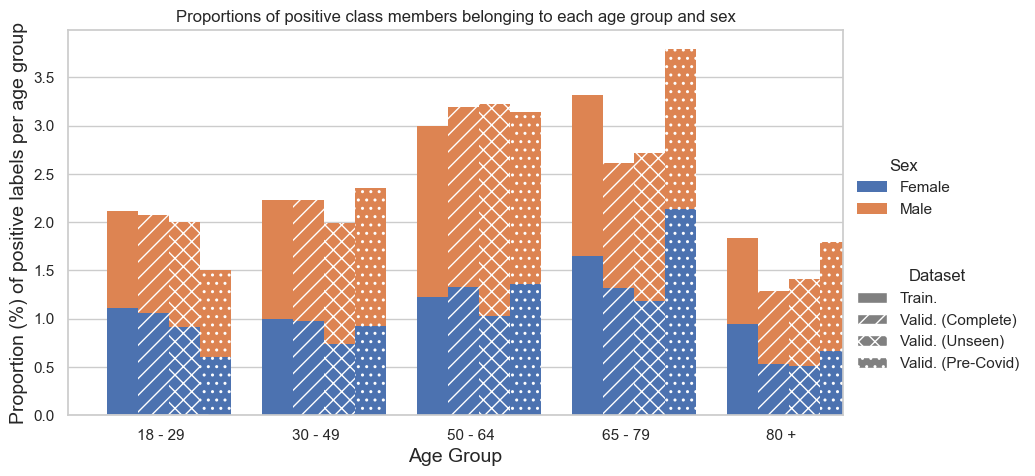

In [144]:
from utils.revision import plot_clustered_stacked

def demographics_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))

    dfs = {}
    for dataset_name, df in list(DATASET_VARIANTS.items())[1:]:
        df = df[['Female', 'AgeBand', 'CriticalEvent']].copy()
        df['Female'] = df.Female.replace({True: "Female", False: "Male"})
        df.loc[df.AgeBand == '17 - 29', 'AgeBand'] = '18 - 29'
        df = df.groupby(['AgeBand', 'Female']).CriticalEvent.sum()/df.groupby(['AgeBand']).CriticalEvent.count()*100
        df = df.drop('16 and Under', level=0, errors='ignore').reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='AgeBand').CriticalEvent
        dfs[dataset_name] = df

    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')


demographics_barplot(save=Notebook.IMAGE_DIR/'age_sex_bars.svg')